# Workflow Examples 


`xclim` is built on very powerful multiprocessing and distributed computation libraries, notably `xarray` and `dask`.

`xarray` is a python package making it easy to work with n-dimensional arrays. It labels axes with their names `[time, lat, lon, level]` instead of indices `[0,1,2,3]`, reducing the likelihood of bugs and making the code easier to understand. One of the key strengths of `xarray` is that it knows how to deal with non-standard calendars (we're looking at you, "`360_days`") and can easily resample daily time series to weekly, monthly, seasonal or annual periods.  Finally, `xarray` is tightly inegrated with `dask`, a package that can automatically parallelize operations.

The following are a few examples to consult when using `xclim` to subset netCDF arrays and compute climate indicators, taking advantage of the parallel processing capabilities offered by `xarray` and `dask`. For more information about these projects, please see their documentation pages:

* **[xarray documentation](https://xarray.pydata.org/en/stable/)**
* **[dask documentation](https://docs.dask.org/en/stable/)**

## Environment configuration

In [2]:
# Imports for xclim and xarray
import xclim.indices as indices
import xclim.atmos as atmos
import numpy as np
import xarray as xr


# plotting
import matplotlib.pyplot as plt

# File handling libraries
import os
import glob
import time
import tempfile
from pathlib import Path

# Output folder
output_folder = Path(tempfile.mkdtemp()) 

## Setting up the Dask client: parallel processing

First we create a pool of workers that will wait for jobs. The `xarray` library will automatically connect to these workers and and dispatch them jobs that can be run in parallel.  

The dashboard link lets you see in real time how busy those workers are.

* **[dask distributed documentation](https://distributed.dask.org/en/latest/)**



In [3]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
client=Client(n_workers=2, threads_per_worker=4, memory_limit="4GB") 
client

<Client: scheduler='tcp://127.0.0.1:42401' processes=2 cores=8>

## Creating xarray datasets

To open a netCDF file with `xarray`, we use `xr.open_dataset(<path to file>)`. By default, the entire file is stored in one chunk, so there is no parallelism. To trigger parallel computations, we need to explicitly specify the ***chunk size***. 

`dask`'s parallelism is based on memory chunks. We need to tell `xarray` to split our netCDF array into chunks of a given size, and operations on each chunk of the array will automatically be dispatched to the workers. 

In [5]:
# This file is opened as one big chunk: no parallel processing.

os.chdir('/home/travis/doris/ClimateData/scen3_scenario/netcdf')
data_source = "ouranos/cb-oura-1.0"
rcps = ["rcp85"]
variable = "tasmax"
rcp = rcps[0]
time_step = "day"

search_str = os.path.join(data_source,'*{v}*CanESM2*{r}*.nc'.format(v=variable,r=rcp))
print(search_str)
sim_files= sorted(glob.glob(search_str))

print(len(sim_files))

ouranos/cb-oura-1.0/*tasmax*CanESM2*rcp85*.nc
151


In [6]:
# Chunking in memory along the time dimension.
# Note that the data type is a 'dask.array'. xarray will automatically use client workers.
ds = xr.open_dataset(sim_files[0], chunks={'time': 31})

print(ds.tasmax, '\n\n', ds.tasmax.chunks)

<xarray.DataArray 'tasmax' (time: 365, lat: 700, lon: 1064)>
dask.array<shape=(365, 700, 1064), dtype=float32, chunksize=(31, 700, 1064)>
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 1950-12-31 00:00:00
  * lat      (lat) float32 83.28931 83.20598 83.12265 ... 25.12497 25.04164
  * lon      (lon) float32 -141.04314 -140.9598 ... -52.54667 -52.46334
Attributes:
    units:          K
    long_name:      air_temperature
    standard_name:  air_temperature 

 ((31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 24), (700,), (1064,))


## Multi-file datasets

NetCDF files are often split into periods to keep file size manageable. A single dataset can be split in dozens of individual files. `xarray` has a function `open_mfdataset` that can open and aggregate a list of files and construct a unique *logical* dataset. `open_mfdataset` can aggregate files over coordinates (time, lat, lon) and variables. 

* Note that opening a multi-file dataset automatically chunks the array (one chunk per file).
* Note also that because `xarray` reads every file metadata to place it in a logical order, it can take a while to load. 

In [24]:
# Create multi-file data & chunks 
ds = xr.open_mfdataset(sim_files, chunks={'time':365, 'lat':50, 'lon':56}, drop_variables=['time_vectors','ts'])
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 700, lon: 1064, time: 55115)
Coordinates:
  * lat      (lat) float32 83.28931 83.20598 83.12265 ... 25.12497 25.04164
  * lon      (lon) float32 -141.04314 -140.9598 ... -52.54667 -52.46334
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<shape=(55115, 700, 1064), chunksize=(365, 50, 56)>
Attributes:
    Conventions:     CF-1.5
    title:           CanESM2 model output prepared for CMIP5 historical
    history:         2011-04-14T00:21:01Z CMOR rewrote data to comply with CF...
    institution:     CCCma (Canadian Centre for Climate Modelling and Analysi...
    source:          CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35) ocean:...
    redistribution:  Redistribution prohibited. For internal use only.


## Subsetting utilities
### subset_bbox : using a latitude-longitude bounding box

In [25]:
from xclim import subset
lat_bnds = [45, 60]
lon_bnds = [-55, -82]

ds1 = subset.subset_bbox(ds,lat_bnds=lat_bnds,lon_bnds=lon_bnds)

print(ds1)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 324, time: 55115)
Coordinates:
  * lat      (lat) float32 59.95691 59.87358 59.79025 ... 45.12417 45.04084
  * lon      (lon) float32 -81.96216 -81.87883 -81.7955 ... -55.1299 -55.04657
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<shape=(55115, 180, 324), chunksize=(365, 20, 19)>
Attributes:
    Conventions:     CF-1.5
    title:           CanESM2 model output prepared for CMIP5 historical
    history:         2011-04-14T00:21:01Z CMOR rewrote data to comply with CF...
    institution:     CCCma (Canadian Centre for Climate Modelling and Analysi...
    source:          CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35) ocean:...
    redistribution:  Redistribution prohibited. For internal use only.


### Add start and/or end years

Note - in the next release, ```xclim.subset``` will use datetime objects instead of a year integer to specify start and end points.

In [26]:
ds2 = subset.subset_bbox(ds,lat_bnds=lat_bnds,lon_bnds=lon_bnds, start_yr=2015, end_yr=2030)
print(ds2, "\n")

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 324, time: 5840)
Coordinates:
  * lat      (lat) float32 59.95691 59.87358 59.79025 ... 45.12417 45.04084
  * lon      (lon) float32 -81.96216 -81.87883 -81.7955 ... -55.1299 -55.04657
  * time     (time) object 2015-01-01 00:00:00 ... 2030-12-31 00:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<shape=(5840, 180, 324), chunksize=(365, 20, 19)>
Attributes:
    Conventions:     CF-1.5
    title:           CanESM2 model output prepared for CMIP5 historical
    history:         2011-04-14T00:21:01Z CMOR rewrote data to comply with CF...
    institution:     CCCma (Canadian Centre for Climate Modelling and Analysi...
    source:          CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35) ocean:...
    redistribution:  Redistribution prohibited. For internal use only. 



### Subset years only

`xclim.subset` can also be used to subset only time periods (i.e. keep the original spatial grid)

In [27]:
# subset years only
ds2 = subset.subset_bbox(ds, start_yr=2015, end_yr=2030)
print(ds2)

<xarray.Dataset>
Dimensions:  (lat: 700, lon: 1064, time: 5840)
Coordinates:
  * lat      (lat) float32 83.28931 83.20598 83.12265 ... 25.12497 25.04164
  * lon      (lon) float32 -141.04314 -140.9598 ... -52.54667 -52.46334
  * time     (time) object 2015-01-01 00:00:00 ... 2030-12-31 00:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<shape=(5840, 700, 1064), chunksize=(365, 50, 56)>
Attributes:
    Conventions:     CF-1.5
    title:           CanESM2 model output prepared for CMIP5 historical
    history:         2011-04-14T00:21:01Z CMOR rewrote data to comply with CF...
    institution:     CCCma (Canadian Centre for Climate Modelling and Analysi...
    source:          CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35) ocean:...
    redistribution:  Redistribution prohibited. For internal use only.


### Selecting a single grid point 
`subset_gridpoint` can be used for selecting single locations

In [11]:
lon_pt = -70.0
lat_pt = 50.0

ds3 = subset.subset_gridpoint(ds,lon=lon_pt,lat=lat_pt, start_yr=1981, end_yr=2010)
print(ds3)

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
    lat      float32 50.04064
    lon      float32 -69.96264
  * time     (time) object 1981-01-01 00:00:00 ... 2010-12-31 00:00:00
Data variables:
    tasmax   (time) float32 dask.array<shape=(10950,), chunksize=(365,)>
Attributes:
    Conventions:     CF-1.5
    title:           CanESM2 model output prepared for CMIP5 historical
    history:         2011-04-14T00:21:01Z CMOR rewrote data to comply with CF...
    institution:     CCCma (Canadian Centre for Climate Modelling and Analysi...
    source:          CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35) ocean:...
    redistribution:  Redistribution prohibited. For internal use only.


#### Create a plot  of subsetted data

Text(0, 0.5, 'daily maximum temperature (°K)')

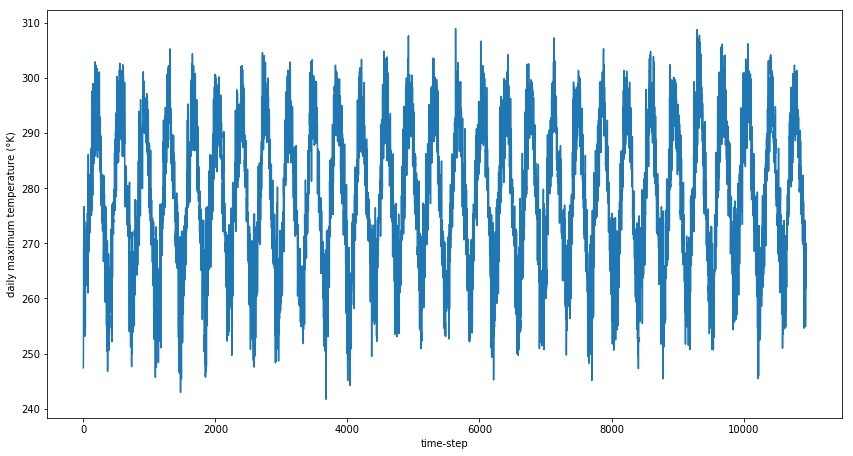

In [11]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5*1.5, 5*1.5]
plt.plot(ds3.tasmax)
plt.xlabel('time-step')
plt.ylabel(f'daily maximum temperature (\u00b0{ds3.tasmax.units})')

## Climate index calculation & resampling frequencies

`xclim` has two layers for the calculation of indicators. The bottom layer is composed of a list of functions that take a `xarray.DataArray` as an input and return an `xarray.DataArray` as output. You'll find these functions in `xclim.indices`. The indicator's logic is contained in this function, as well as potential unit conversions, but it doesn't check if the time frequency is daily, and doesn't not adjust the meta data of the output array. 

The second layer are class instances that you'll find organized by *realm*. So far, there is only one realm (atmospheric) available in `xclim.atmos`, but we'll be working on `ice` and `land` indicators in 2020. Before running computations, these classes check the input data is a daily average of the expected variable:

1. If an indicator expects a daily mean and you pass it a daily max, a `warning` will be raised. 
2. After the computation, it also checks the number of values per period to make sure there are not missing values or `NaN` in the input data. If there are, the output is going to be set to `NaN`. 
3. The output units are set correctly as well as other properties of the output array, complying as much as possible with CF conventions. 

For new users, we suggest you use the classes found in `xclim.atmos`. If you know what you're doing and you want to circumvent the built-in checks, then you can use the `xclim.indices` directly. 

All `xclim` indicators convert daily data to lower time frequencies, such as monthly or annual values. This is done using `xarray.DataArray.resample` method. Resampling creates a grouped object over which you apply a reduction operation (e.g. mean, min, max). The list of available frequency is given in the link below, but the most often used are: 

- YS: annual starting in January
- YS-JUL: annual starting in July
- MS: monthly
- QS-DEC: seasonal starting in December
- 7D: 7 day (weekly)


http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases  
Note - not all offsets in the link are supported by cftime objects in `xarray`


In the example below, we're computing the **annual maximum temperature of the daily maximum temperature (tx_max)**

In [12]:
fr = 'YS'
ds1.tasmax.attrs['cell_methods'] = 'time: maximum within days'
out = atmos.tx_max(ds1.tasmax, freq=fr)
print(f'Number of time-steps using freq == {fr} : {len(out.time)}\n')
print(out.time)

Number of time-steps using freq == YS : 151

<xarray.DataArray 'time' (time: 151)>
array([cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, 4, 1),
       cftime.DatetimeNoLeap(1951, 1, 1, 0, 0, 0, 0, 5, 1),
       cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0, 6, 1),
       cftime.DatetimeNoLeap(1953, 1, 1, 0, 0, 0, 0, 0, 1),
       cftime.DatetimeNoLeap(1954, 1, 1, 0, 0, 0, 0, 1, 1),
       cftime.DatetimeNoLeap(1955, 1, 1, 0, 0, 0, 0, 2, 1),
       cftime.DatetimeNoLeap(1956, 1, 1, 0, 0, 0, 0, 3, 1),
       cftime.DatetimeNoLeap(1957, 1, 1, 0, 0, 0, 0, 4, 1),
       cftime.DatetimeNoLeap(1958, 1, 1, 0, 0, 0, 0, 5, 1),
       cftime.DatetimeNoLeap(1959, 1, 1, 0, 0, 0, 0, 6, 1),
       cftime.DatetimeNoLeap(1960, 1, 1, 0, 0, 0, 0, 0, 1),
       cftime.DatetimeNoLeap(1961, 1, 1, 0, 0, 0, 0, 1, 1),
       cftime.DatetimeNoLeap(1962, 1, 1, 0, 0, 0, 0, 2, 1),
       cftime.DatetimeNoLeap(1963, 1, 1, 0, 0, 0, 0, 3, 1),
       cftime.DatetimeNoLeap(1964, 1, 1, 0, 0, 0, 0, 4, 1),
       cftime.Dat

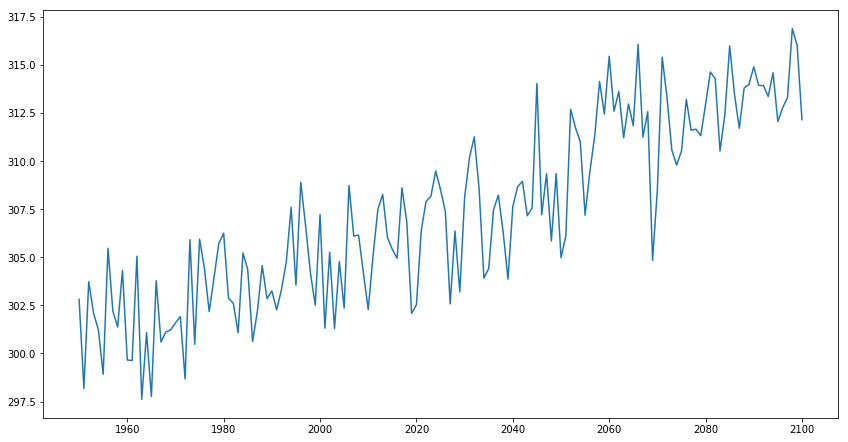

In [51]:
out1 = subset.subset_gridpoint(out,lon=lon_pt, lat=lat_pt)
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5*1.5, 5*1.5]
plt.plot(out1.time.dt.year, out1)

## Comparison of **atmos** vs **indices** modules
Both the `atmos` and `indices` modules provide access to `xclim` climate index algorithms. However, the `atmos` module additonally :
* adds CF metadata attributes to the output variable
* performs checks for missing values and incomplete resampling periods and assigns them as `nan`. <br>
    *note : currently these checks are very strict - a single missing day will result in the entire resample period being flagged as `nan`*
* performs a check on the input data cell-methods attribute and gives a warning if different than expected 

In [28]:
ds2 = subset.subset_bbox(ds1, start_yr=1981, end_yr=2050)

out = indices.tx_days_above(ds2.tasmax,thresh='30 C',freq=fr)
print('Example output using indices module : \n\n', out,'\n\n')

out = atmos.tx_days_above(ds2.tasmax,thresh='30 C',freq=fr)
print('Example output using atmos module : Output data has added CF metadata attributes\n\n', out,'\n\n\n',)

Example output using indices module : 

 <xarray.DataArray 'tasmax' (time: 70, lat: 180, lon: 324)>
dask.array<shape=(70, 180, 324), dtype=int64, chunksize=(1, 20, 19)>
Coordinates:
  * time     (time) object 1981-01-01 00:00:00 ... 2050-01-01 00:00:00
  * lat      (lat) float32 59.95691 59.87358 59.79025 ... 45.12417 45.04084
  * lon      (lon) float32 -81.96216 -81.87883 -81.7955 ... -55.1299 -55.04657
Attributes:
    units:    days 


Example output using atmos module : Output data has added CF metadata attributes

 <xarray.DataArray 'tx_days_above' (time: 70, lat: 180, lon: 324)>
dask.array<shape=(70, 180, 324), dtype=float64, chunksize=(1, 20, 19)>
Coordinates:
  * time     (time) object 1981-01-01 00:00:00 ... 2050-01-01 00:00:00
  * lat      (lat) float32 59.95691 59.87358 59.79025 ... 45.12417 45.04084
  * lon      (lon) float32 -81.96216 -81.87883 -81.7955 ... -55.1299 -55.04657
Attributes:
    units:          days
    history:        [2019-06-28 10:42:14] tx_days_above: tx_da

In [29]:
# We have created an xarray data-array - We can insert this into an output xr.Dataset object with a copy of the original dataset global attrs
dsOut = xr.Dataset(data_vars=None, coords=out.coords, attrs=ds1.attrs)

# Add our climate index as a data variable to the dataset
dsOut[out.name] = out
print(dsOut)

<xarray.Dataset>
Dimensions:        (lat: 180, lon: 324, time: 70)
Coordinates:
  * time           (time) object 1981-01-01 00:00:00 ... 2050-01-01 00:00:00
  * lat            (lat) float32 59.95691 59.87358 ... 45.12417 45.04084
  * lon            (lon) float32 -81.96216 -81.87883 ... -55.1299 -55.04657
Data variables:
    tx_days_above  (time, lat, lon) float64 dask.array<shape=(70, 180, 324), chunksize=(1, 20, 19)>
Attributes:
    Conventions:     CF-1.5
    title:           CanESM2 model output prepared for CMIP5 historical
    history:         2011-04-14T00:21:01Z CMOR rewrote data to comply with CF...
    institution:     CCCma (Canadian Centre for Climate Modelling and Analysi...
    source:          CanESM2 2010 atmosphere: CanAM4 (AGCM15i, T63L35) ocean:...
    redistribution:  Redistribution prohibited. For internal use only.


## *Lazy* computation - Nothing has been computed so far !

If you look at the output of those operations, they're identified as `dask.array` objects. What happens is that `dask` creates a chain of operations that when executed, will yield the values we want. We have thus far only created a schedule of tasks with a small preview and not done any actual computations. You can trigger computations by using the `load` or `compute` method, or writing the output to disk via `to_netcdf`.

In [30]:
output_file = output_folder / 'test_tx_max.nc'
start= time.time()
dsOut.to_netcdf(output_file, format='NETCDF4')
end = time.time()

print('calculation took {} seconds'.format(end-start))

calculation took 98.54578709602356 seconds


### Performance tips
#### Optimizing the chunk size

You can improve performance by being smart about chunk sizes. If chunks are too small, there is a lot of time lost in overhead. If chunks are too large, you may end up exceeding the individual worker memory limit.

In [31]:
print(ds2.chunks['lon'], ds2.chunks['lat'])

(19, 56, 56, 56, 56, 56, 25) (20, 50, 50, 50, 10)


In [32]:
# rechunk data in memory for the entire grid  
ds2 = ds2.chunk(chunks={'time':365, 'lon':-1, 'lat':-1})
print('lon chunks : ',ds2.chunks['lon'], 'lat chunks : ',ds2.chunks['lat'])

lon chunks :  (324,) lat chunks :  (180,)


In [33]:
out = atmos.tx_max(ds2.tasmax, freq=fr)
dsOut = xr.Dataset(data_vars=None, coords=out.coords, attrs=ds1.attrs)
dsOut[out.name] = out

output_file = output_folder / 'test_tx_max.nc'
start= time.time()
dsOut.to_netcdf(output_file, format='NETCDF4')
end = time.time()

print('calculation took {} seconds'.format(end-start))

calculation took 61.184327363967896 seconds


## Unit handling in `xclim`

A lot of effort has been placed into automatic handling of input data units. `xclim` will automatically detect the input variable(s) units (e.g. °C versus °K or mm/s versus mm/day etc.) and adjust on-the-fly in order to calculate indices in the consistent manner. This comes with the obvious caveat that input data requires metadata attribute for units

In the example below, we compute weekly total precipitation in mm using inputs of mm/s and mm/d:

In [34]:
dsPr = xr.open_dataset(sim_files[0].replace('tasmax','pr'),chunks={'time':31})

dsPr = subset.subset_gridpoint(dsPr,lon=lon_pt,lat=lat_pt)

# Create a copy of the data converted to mm d-1
dsPr_mmd = dsPr.copy()
dsPr_mmd["pr"].values = dsPr.pr.values * 3600 *24
dsPr_mmd.pr.attrs["units"] = "mm d-1"

print(dsPr.pr.values[0:31],"\n")
print(dsPr_mmd.pr.values[0:31])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 8.9340929e-06 3.5076929e-04 1.2942391e-05 9.0236499e-06 0.0000000e+00
 0.0000000e+00 5.5392566e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0515173e-04 1.1709578e-04
 1.5363095e-05 5.3604645e-06 6.8759164e-06 6.3503167e-06 8.5290767e-06
 1.5942713e-05 2.4701996e-05 0.0000000e+00 1.9558065e-05 3.8041471e-05
 1.7530168e-05] 

[ 0.          0.          0.          0.          0.          0.7719056
 30.306467    1.1182226   0.7796433   0.          0.          0.4785918
  0.          0.          0.          0.          0.          0.
  9.08511    10.117075    1.3273714   0.46314412  0.59407914  0.5486674
  0.7369122   1.3774505   2.1342525   0.          1.689817    3.2867832
  1.5146066 ]


In [35]:
out1 = atmos.precip_accumulation(dsPr.pr, freq='MS')
print('1. results using inputs in mm/s : \n\n','units : {}'.format(out1.units),'\n',out1.values,'\n')

out2 = atmos.precip_accumulation(dsPr_mmd.pr, freq='MS')
print("2. results using inputs in mm/d : \n\n","units : {}".format(out2.units),'\n',out2.values,'\n')
   

1. results using inputs in mm/s : 

 units : mm 
 [ 66.33009   54.882748  36.440014 101.48769   33.541607  87.78063
 104.287926 131.6258    90.1462    51.02812   76.28108   50.558487] 

2. results using inputs in mm/d : 

 units : mm 
 [ 66.3301    54.882748  36.44001  101.48769   33.541603  87.78063
 104.287926 131.62578   90.1462    51.02812   76.28108   50.558487] 



### Threshold indices

`xclim` unit handling also applies to threshold indicators. Users can provide threshold in units of choice and `xclim` will adjust automatically. For example determining the number of days with tasmax > 20°C users can define a threshold input of '20 C' or '20 degC' even if input data is in Kelvin. Alernatively users can even provide a threshold in Kelvin '293.15 K' (if they really wanted to).

In [36]:
# Original data in Kelvin
dsTasmax = xr.open_dataset(sim_files[0],chunks={'time':31})
dsTasmax.tasmax.attrs['cell_methods'] = 'time: maximum within days'
dsTasmax = subset.subset_gridpoint(dsTasmax,lon=lon_pt,lat=lat_pt)

# Create a copy of the data converted to C
dsTasmax_C = dsTasmax.copy()
dsTasmax_C['tasmax'].values = dsTasmax.tasmax.values - 273.15
dsTasmax_C.tasmax.attrs['units'] = 'C'

print(dsTasmax.tasmax.values[0:31],'\n')
print(dsTasmax_C.tasmax.values[0:31])


[273.52423 271.8584  247.72333 252.86673 264.26947 273.6165  274.6312
 266.9458  249.10762 255.10834 263.67825 265.15714 253.79906 260.2457
 261.9232  267.89328 268.66718 268.50583 268.02005 268.0124  256.60968
 248.05493 247.59552 248.5298  248.72592 248.59483 250.02737 247.43605
 249.71368 250.91469 249.64064] 

[  0.37423706  -1.2915955  -25.426666   -20.283264    -8.880524
   0.4664917    1.4812012   -6.204193   -24.042374   -18.041656
  -9.471741    -7.992859   -19.350937   -12.904297   -11.226807
  -5.256714    -4.4828186   -4.644165    -5.129944    -5.1376038
 -16.540314   -25.095062   -25.554474   -24.620193   -24.424072
 -24.55516    -23.12262    -25.713943   -23.43631    -22.235306
 -23.509354  ]


In [37]:
# Using Kelvin data
out1 = atmos.tx_days_above(dsTasmax.tasmax,thresh='20 C', freq='MS')
print('1. results using inputs in °K  : threshold in °C: \n\n',out1.values,'\n')

# Using Celsius data
out2 = atmos.tx_days_above(dsTasmax_C.tasmax,thresh='20 C', freq='MS')
print('2. results using inputs in °C : threshold in °C\n\n',out2.values)

# Using Celsius but with threshold in Kelvin
out3 = atmos.tx_days_above(dsTasmax_C.tasmax,thresh='293.15 K', freq='MS')
print('\n3. results using inputs in °C : threshold in °K : \n\n',out3.values)


1. results using inputs in °K  : threshold in °C: 

 [ 0.  0.  0.  0.  4. 14. 16. 16.  3.  0.  0.  0.] 

2. results using inputs in °C : threshold in °C

 [ 0.  0.  0.  0.  4. 14. 16. 16.  3.  0.  0.  0.]

3. results using inputs in °C : threshold in °K : 

 [ 0.  0.  0.  0.  4. 14. 16. 16.  3.  0.  0.  0.]
